# DEEP NEURAL NETWORK 

### Importing libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid', palette='hls')

import torch 
from torchvision.transforms import ToTensor
from torch import nn 
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

### Tabular data

In [2]:
class Dataset_Custom(Dataset):
    def __init__(self, X_data, Y_data):
        X_data = X_data
        Y_data = Y_data
        self.x, self.y = self.clean(X_data, Y_data)
        self.samples = self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] 

    def __len__(self):
        return self.samples

    def clean(self,X_data,Y_data):
        scaler = StandardScaler()
        data_x = scaler.fit_transform(X_data)
        x = torch.from_numpy(data_x).float()
        y = torch.from_numpy(Y_data.values).float()
        y = y[:,None]
        return x,y


### Separating into training and testing

In [3]:
file = './data_processed/embeddings_spacy.csv'
data = pd.read_csv(file, index_col=0)

X = data.iloc[:,:-1]
y = data[data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20, shuffle=True)

print("X_train {} y_train {} \nX_test {} y_test {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

dataset_train = Dataset_Custom(X_train, y_train)
dataset_test = Dataset_Custom(X_test, y_test)

X_train (5482, 99) y_train (5482,) 
X_test (1371, 99) y_test (1371,)


### Using DataLoaders for both sets

In [4]:
batch = 30

trainloader = DataLoader(dataset=dataset_train, batch_size=batch, shuffle=True)
testloader = DataLoader(dataset=dataset_test, batch_size=batch, shuffle=True)

### Function to build the model

In [5]:
def build_model(input_size, hidden_sizes, output_size, activation_functions):
    layers = []
    layer_sizes = [input_size] + hidden_sizes + [output_size]
    
    # Add hidden layers
    for i in range(1, len(layer_sizes)):
        layers.append(('fc{}'.format(i), nn.Linear(layer_sizes[i-1], layer_sizes[i])))
        if activation_functions[i-1] == 'relu':
            layers.append(('relu{}'.format(i), nn.ReLU()))
        elif activation_functions[i-1] == 'sigmoid':
            layers.append(('sigmoid{}'.format(i), nn.Sigmoid()))

    model = nn.Sequential(OrderedDict(layers))
    return model

### Training the model

Exactitud: 0.53
Precisión: 0.52
Puntuación F1: 0.53


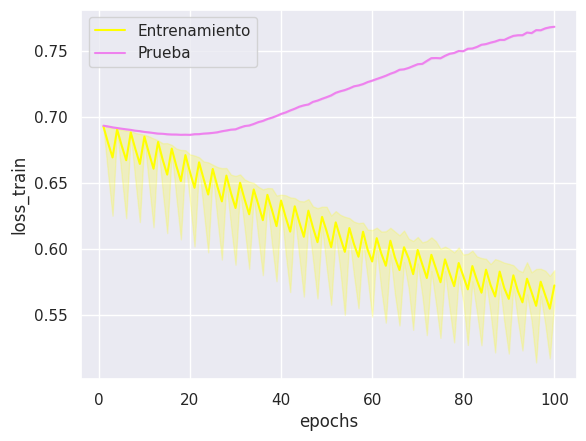

In [46]:
# Hyperparameters for our network
input_size = X.shape[1]
hidden_sizes = [16,16,16]
output_size = 1
activation_functions = ['relu','relu','relu','sigmoid']

model = build_model(input_size, hidden_sizes, output_size, activation_functions)
# Entrenamiento por epocas

# Definition of loss, learning rate & epochs
learning_rate = 0.0001

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

epochs = 100
print_every = int((X_train.shape[0]/batch) / 20)
steps = 0 
list_loss = []
list_loss_test = []
list_epochs = []

# Comenzando entrenamiento. . . 
for e in range(epochs):
    running_loss = 0
    # En cada epoca cargamos todos los batches 
    for inputs, labels in iter(trainloader):
        steps += 1
        # Reiniciar los gradientes
        optimizer.zero_grad()
        # Forward pass
        outputs = model.forward(inputs)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Backprogation
        loss.backward()
        # Actualiza los pesos de acuerdo a un paso del optimizador
        optimizer.step()
        # Guardamos la perdida para control del entrenamiento
        running_loss += loss.item()
        # imprimimos cada 20% lotes
        if steps % print_every == 0:
            list_loss.append(running_loss/print_every)
            running_loss = 0
            
            output_test = model.forward(dataset_test.x)
            loss_t = criterion(output_test, dataset_test.y)
            list_loss_test.append(loss_t.item())
            list_epochs.append(e+1)
        
df = pd.DataFrame()
df['epochs'] = list_epochs
df['loss_train'] = list_loss
df['loss_test'] = list_loss_test

sns.set_theme(style="darkgrid")

sns.lineplot(x="epochs", y="loss_train", data=df, color='yellow', label='Entrenamiento')
sns.lineplot(x="epochs", y="loss_test", data=df, color='violet', label='Prueba')

output_acc = model.forward(dataset_test.x)

# Medidas
pred = torch.unsqueeze(torch.tensor([ 0 if p<=0.5 else 1 for p in output_acc]),1)
label = dataset_test.y
pred = pred.numpy()
label = label.numpy()

# Calcular la exactitud
exactitud = round(accuracy_score(label, pred),2)
print("Exactitud:", exactitud)

# Calcular la preci sión
precision = round(precision_score(label, pred),2)
print("Precisión:", precision)

# Calcular la puntuación F1
f1 = round(f1_score(label, pred),2)
print("Puntuación F1:", f1)